In [171]:
%matplotlib inline
import numpy as np
import datetime
import json
import pandas as pd
import os
import requests
import scipy
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [172]:
# The file was generated by the weather script.
filename = '../data/weather_daily_2018-12-31_2020-03-12.json'

if not os.path.exists(filename):
    raise 'file not exists'

with open(filename) as f:
    data = json.load(f)

In [173]:
# json into dataframe
df = pd.DataFrame(data).T

# will drop any column not listed here
selection = """
summary, icon, precipIntensity, precipIntensityMax,
precipProbability, temperatureHigh, temperatureLow,
windSpeed, windGust, cloudCover
"""
selection = [col.strip() for col in selection.split(',')]
for col in df.columns:
    if col not in selection:
        del df[col]
    elif col not in ['summary', 'icon']:
        # set column type to float
        df[col] = df[col].astype('float')

In [174]:
df.describe()

,precipIntensity,precipIntensityMax,precipProbability,temperatureHigh,temperatureLow,windSpeed,windGust,cloudCover
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,0.007118,0.030442,0.388014,80.172968,62.789703,6.248425,15.765616,0.590297
std,0.011589,0.054009,0.318582,7.567911,5.827456,1.868370,4.675379,0.290695
min,0.000000,0.000000,0.000000,55.030000,40.510000,2.750000,4.680000,0.000000
25%,0.000300,0.001300,0.080000,75.590000,59.455000,4.702500,12.572500,0.340000
50%,0.002200,0.009150,0.325000,81.265000,63.645000,6.000000,15.230000,0.640000
75%,0.009275,0.041450,0.677500,85.647500,67.087500,7.557500,18.215000,0.850000
max,0.100800,0.729400,1.000000,96.300000,74.280000,12.480000,31.930000,1.000000


In [175]:
df.index = pd.to_datetime(df.index)

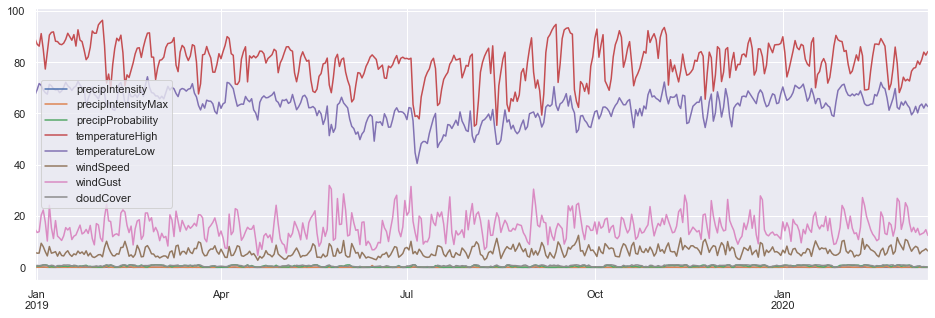

In [176]:
df.plot(figsize=(16,5));

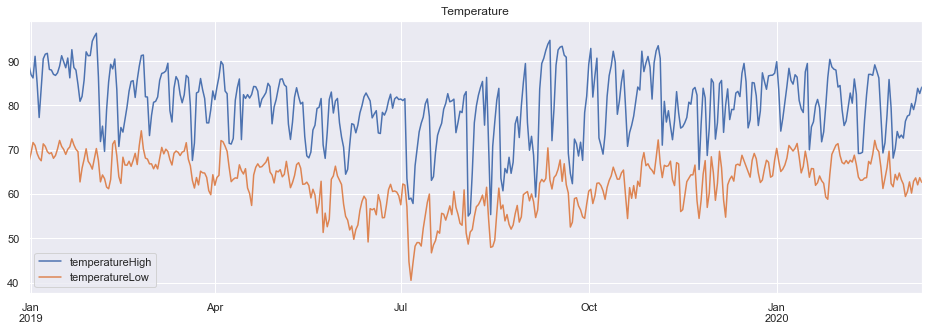

In [177]:
keyword = 'temperature'
selection = [col for col in df.columns if keyword in col.lower()]
df[selection].plot(figsize=(16,5));
plt.title(keyword.capitalize());

These curves never cross each other. We need to register this discovery!

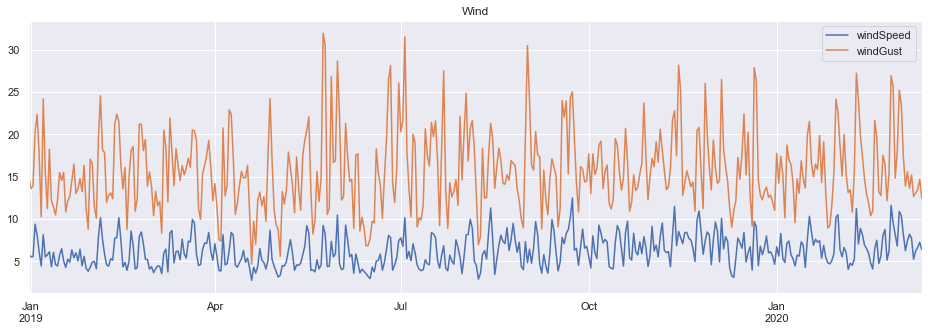

In [178]:
keyword = 'wind'
selection = [col for col in df.columns if keyword in col.lower()]
df[selection].plot(figsize=(16,5));
plt.title(keyword.capitalize());

Two in row! Bring the champagne!

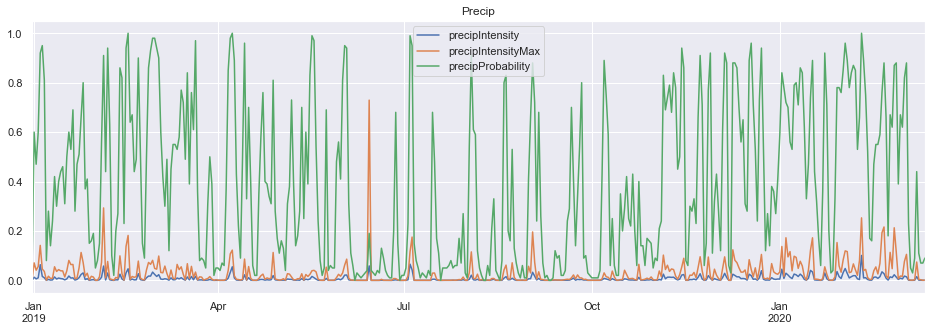

In [179]:
keyword = 'precip'
selection = [col for col in df.columns if keyword in col.lower()]
df[selection].plot(figsize=(16,5));
plt.title(keyword.capitalize());

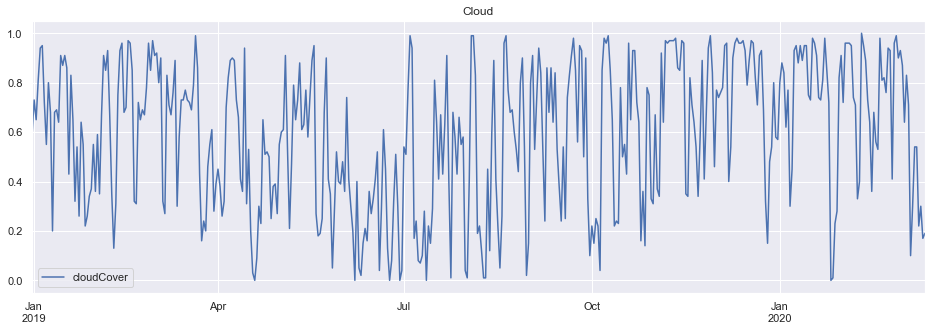

In [180]:
keyword = 'cloud'
selection = [col for col in df.columns if keyword in col.lower()]
df[selection].plot(figsize=(16,5));
plt.title(keyword.capitalize());

Let's see how does it look with column values normalized

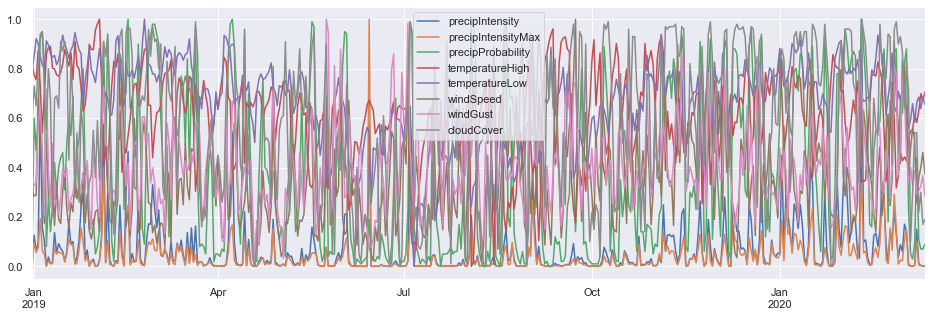

In [181]:
dfn = df.copy()
for col in dfn.columns:
    if col in ['icon', 'summary']: continue
    # normalize
    dfn[col] = (dfn[col]-dfn[col].min())/(dfn[col].max()-dfn[col].min())
    
dfn.plot(figsize=(16,5));

# This is an error. I should normalize the them taking into consideration same unit's columns.
# Example: temperatureHigh and temperatureLow must be normalized as a couple

Nice plot to decorate the living room!

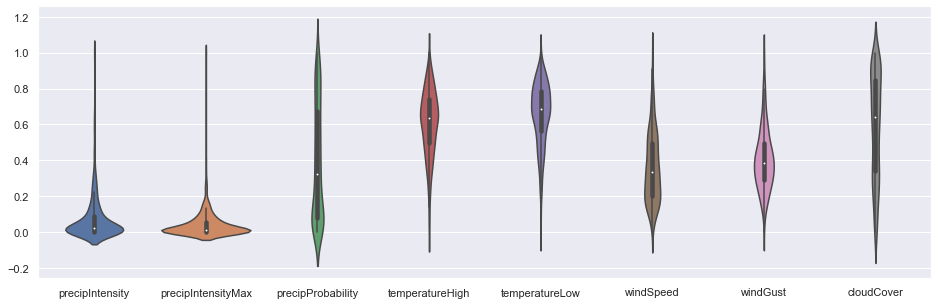

In [182]:
# We should not pay attention to the y value. Just to the distribution form of the normalized values.
selection = [col for col in df.columns if col not in ['icon', 'summary']]
plt.figure(figsize=(16,5))
sns.violinplot(data=dfn, orient='v');

The only normal thing when speacking about weather is: the wind :D

What does the weather icon have to tell?

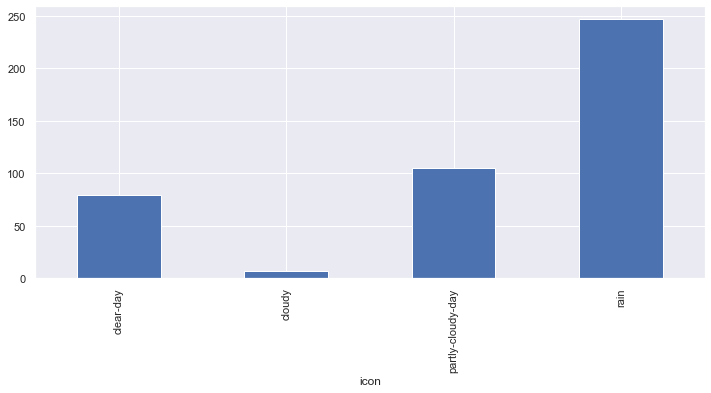

In [183]:
df.groupby('icon')['icon'].count().plot.bar(figsize=(12,5));

What? The weather icon is more likely to be rain in Sao Pablo :S  

In [184]:
i = {'clear-day': 0, 'partly-cloudy-day':0.33, 'cloudy': 0.67, 'rain': 1}
df['iconn'] = df['icon'].apply(lambda x: i[x])

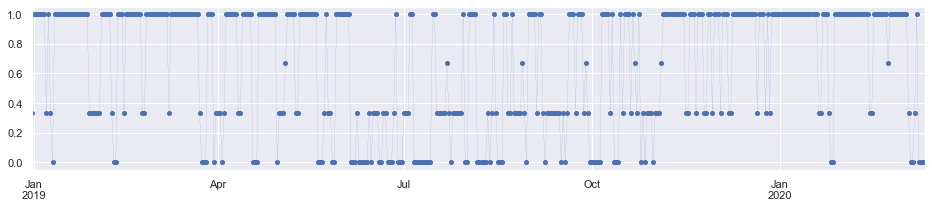

In [185]:
df['iconn'].plot(marker='o', markersize=4, linewidth=0.1, figsize=(16,3));

**What were the rainiest days in global intensity?**

In [186]:
df['precipIntensity'].sort_values(ascending=False).iloc[:10]

2020-02-10    0.1008
2019-07-04    0.0654
2019-01-04    0.0634
2019-06-14    0.0585
2019-02-04    0.0579
2019-04-08    0.0549
2020-02-02    0.0479
2019-02-16    0.0468
2020-01-02    0.0452
2019-07-05    0.0428
Name: precipIntensity, dtype: float64

**What were the rainiest days in max intensity?**

In [187]:
df['precipIntensityMax'].sort_values(ascending=False).iloc[:10]

2019-06-14    0.7294
2019-02-04    0.2931
2020-02-10    0.2529
2020-02-21    0.2160
2020-02-26    0.2128
2019-09-02    0.1959
2020-02-20    0.1927
2019-02-16    0.1818
2019-07-05    0.1752
2020-01-04    0.1724
Name: precipIntensityMax, dtype: float64

**What were the windiest days?**

In [188]:
df['windSpeed'].sort_values(ascending=False).iloc[:10]

2019-09-23    12.48
2020-02-26    11.60
2019-11-12    11.48
2019-08-14    11.31
2020-02-09    11.24
2019-11-24    10.93
2020-03-01    10.88
2020-01-31    10.50
2019-05-31    10.47
2020-03-02    10.41
Name: windSpeed, dtype: float64

**What were the hottest days?**

In [189]:
df['temperatureHigh'].sort_values(ascending=False).iloc[:10]

2019-02-02    96.30
2019-02-01    95.53
2019-09-12    94.70
2019-01-31    94.51
2019-09-11    93.83
2019-11-04    93.49
2019-09-18    93.36
2019-09-17    93.17
2019-10-02    92.87
2019-01-21    92.59
Name: temperatureHigh, dtype: float64

**What were the sunniest days**

In [190]:
df['cloudCover'].sort_values(ascending=True).iloc[:10]

2019-07-12    0.00
2019-06-24    0.00
2019-06-29    0.00
2019-04-19    0.00
2019-06-07    0.00
2020-01-26    0.00
2019-08-01    0.01
2020-01-27    0.01
2019-08-10    0.01
2019-08-09    0.01
Name: cloudCover, dtype: float64

## Load available drivers from agency 1 based on driver historic works

In [191]:
db = global_connect()

In [192]:
# Let's see what happens reading just drivers from availabilities that appears at leas once in itineraries 
# We could be more strict with drivers counting, i.e. using a weight comparison like w.w1 > 0.80
# 
df_dw = careful_query(
"""
SELECT
    a.date,
    COUNT(1) as drivers,
    SUM(CASE WHEN w.w1 > 0 THEN 1 ELSE 0 END) as driver_1, /* means at least works once for agency 1 */
    SUM(CASE WHEN w.w2 > 0 THEN 1 ELSE 0 END) as driver_2  /* means at least works once for agency 2 */,
    SUM(CASE WHEN w.w1 > 0 THEN a.pushes ELSE 0 END) as pushes_1, /* presence in db */
    SUM(CASE WHEN w.w2 > 0 THEN a.pushes ELSE 0 END) as pushes_2 /* presence in db */
FROM driver_weights w
JOIN
    (SELECT DATE(sent) as date, COUNT(sent) as pushes, driver_id
    FROM availabilities
    WHERE distribution_center = 1
    GROUP BY DATE(sent), driver_id) a
ON w.driver_id = a.driver_id
WHERE w.n1 > 1 /* restrict count to drivers with more then 5 itineraries */
GROUP BY a.date
ORDER BY a.date ASC"""
, max_cost = 1400000)

In [193]:
df_dw['date'] = pd.to_datetime(df_dw['date'])
df_dw.set_index('date', inplace=True)

In [194]:
df_d = df_dw.copy()
#df_d.isna().sum()
df_d['pushes_1'] = df_d['pushes_1'].astype('float')
df_d['pushes_2'] = df_d['pushes_2'].astype('float')

In [195]:
idx_null = [d for d in df.index if d not in df_d.index]
idx_null

[Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-03-11 00:00:00'),
 Timestamp('2020-03-12 00:00:00')]

In [196]:
tdf = pd.concat([df_d, df[~df.index.isin(idx_null)]], axis=1)

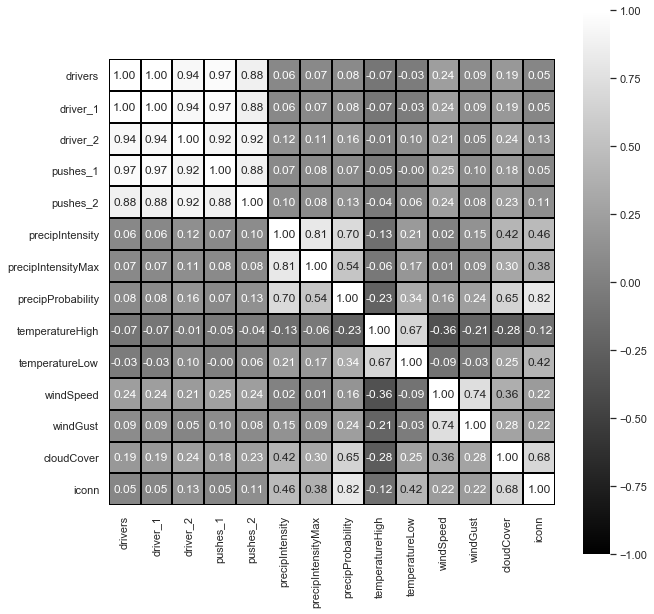

In [197]:
plt.figure(figsize=(10,10))
sns.heatmap(tdf.corr(), vmin=-1, vmax=1, annot = True, square = True,
       center= 0, cmap= 'gray', linewidths=1, linecolor='black', fmt='.2f');

This is really weird. Worst the weather condition, more the number of available drivers :S

**TODO:**  
- Cross the weather dataset with number of itineraries per day

Maybe, the peaks we found in the itineraries analysis are related with this dataset